In [4]:
# TESTING WITH LATEST DATASET (08:00, 28, Friday, December, 2025) -> (22:00, 30, Sunday, December, 2025)

In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

PROM_URL = "http://10.35.29.108:30900/api/v1/query_range"

# Worker-only CPU usage (10.35.29.109 and 10.35.29.110) (Only Worker Node)
CPU_QUERY = r'''(sum(rate(node_cpu_seconds_total{mode!="idle", instance=~"10\\.35\\.29\\.(109|110):9100"}[1m])) /
sum(rate(node_cpu_seconds_total{instance=~"10\\.35\\.29\\.(109|110):9100"}[1m]))) * 100'''

# Pending pods
PENDING_QUERY = r'''sum(kube_pod_status_phase{phase="Pending"})'''

# TIME RANGE (THAILAND UTC+7)
TH = timezone(timedelta(hours=7))
start = datetime(2025, 11, 28, 8, 0, 0, tzinfo=TH)
end   = datetime(2025, 11, 30, 22, 0, 0, tzinfo=TH)
start_ts = start.timestamp()   # converted automatically to UTC for Prometheus
end_ts   = end.timestamp()

print("Querying between:")
print("Local TH start:", start)
print("Local TH end:  ", end)
print("Unix start:", start_ts)
print("Unix end:  ", end_ts)

def query_prometheus(promql):
    params = {
        "query": promql,
        "start": start_ts,
        "end": end_ts,
        "step": "60s"
    }
    response = requests.get(PROM_URL, params=params).json()

    if len(response["data"]["result"]) == 0:
        print("⚠️ No data returned for query:", promql)
        return []

    return response["data"]["result"][0]["values"]

cpu_data = query_prometheus(CPU_QUERY)
pending_data = query_prometheus(PENDING_QUERY)

df_cpu = pd.DataFrame(cpu_data, columns=["timestamp", "cpu"])
df_cpu["timestamp"] = pd.to_datetime(df_cpu["timestamp"], unit="s", utc=True).dt.tz_convert("Asia/Bangkok")
df_cpu["cpu"] = df_cpu["cpu"].astype(float)

df_pending = pd.DataFrame(pending_data, columns=["timestamp", "pending"])
df_pending["timestamp"] = pd.to_datetime(df_pending["timestamp"], unit="s", utc=True).dt.tz_convert("Asia/Bangkok")
df_pending["pending"] = df_pending["pending"].astype(float)

df = pd.merge(df_cpu, df_pending, on="timestamp", how="inner")

df.to_csv("CPU_Usage_&_Pending_Pod_Dateset.csv", index=False)
print("Saved as CPU_Usage_&_Pending_Pod_Dateset.csv")

df.head()

Querying between:
Local TH start: 2025-11-28 08:00:00+07:00
Local TH end:   2025-11-30 22:00:00+07:00
Unix start: 1764291600.0
Unix end:   1764514800.0
Saved as CPU_Usage_&_Pending_Pod_Dateset.csv


,timestamp,cpu,pending
0,2025-11-28 08:00:00+07:00,54.042962,1.0
1,2025-11-28 08:01:00+07:00,54.201317,1.0
2,2025-11-28 08:02:00+07:00,54.644381,1.0
3,2025-11-28 08:03:00+07:00,54.483660,1.0
4,2025-11-28 08:04:00+07:00,54.883033,1.0


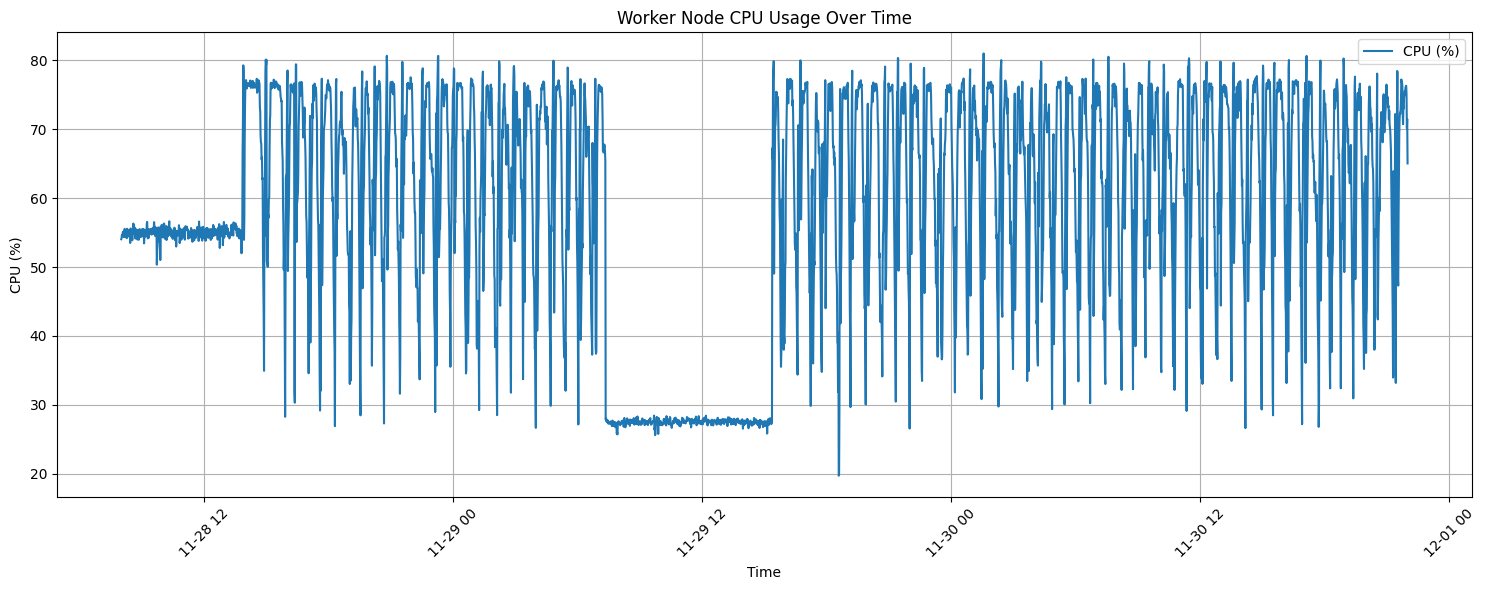

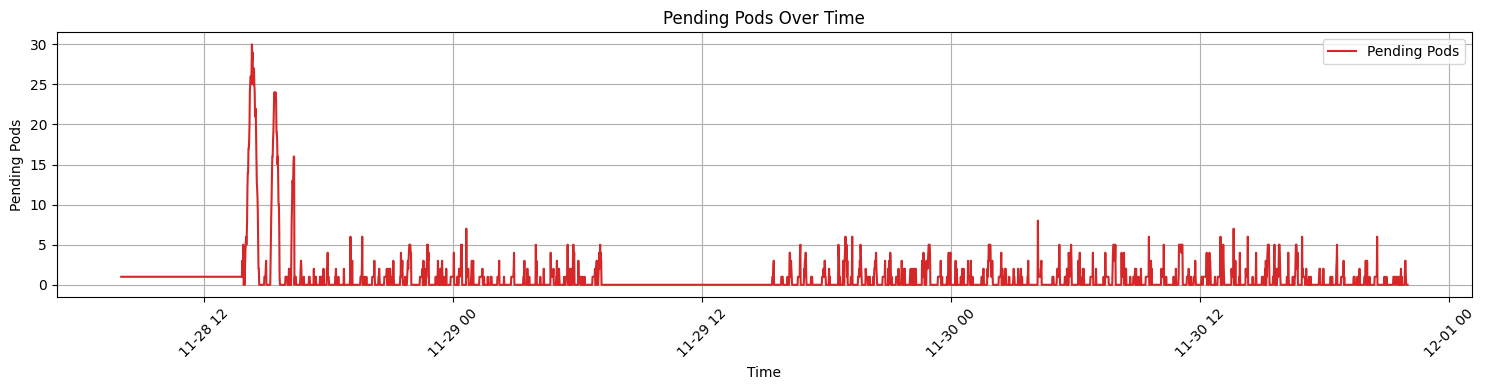

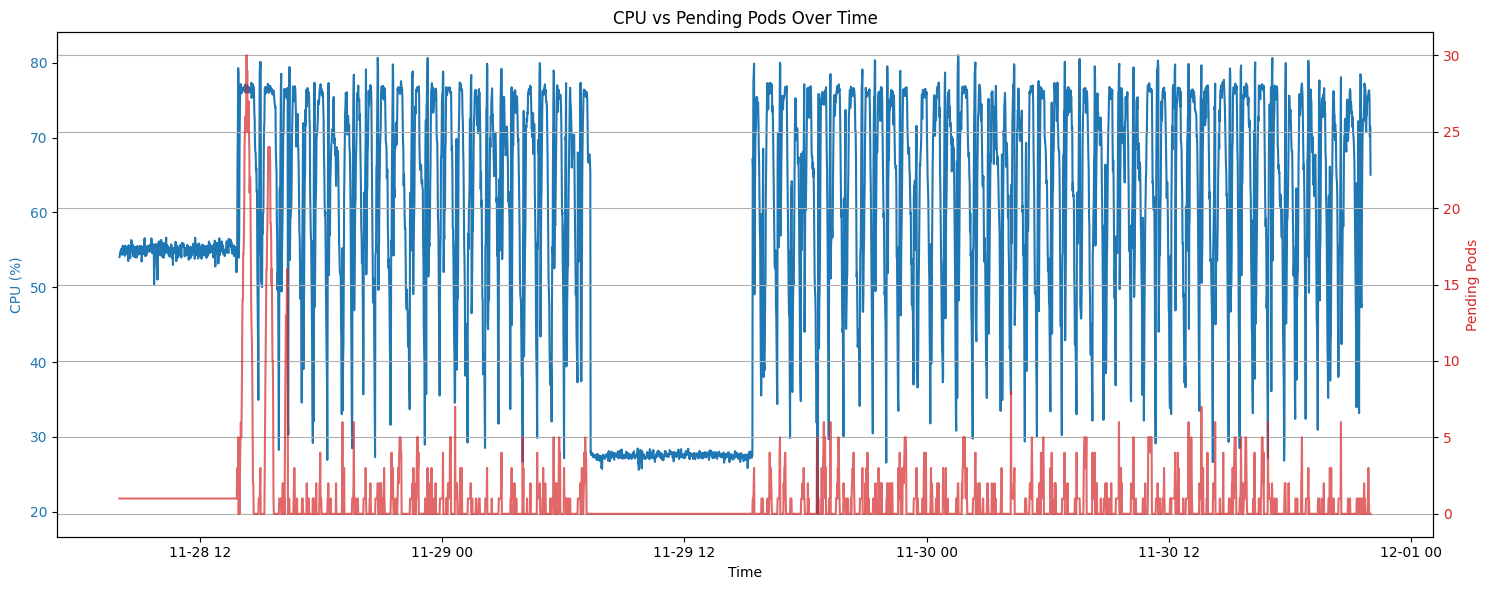

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("CPU_Usage_&_Pending_Pod_Dateset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")


# PLOT CPU USAGE
plt.figure(figsize=(15, 6))
plt.plot(df["timestamp"], df["cpu"], label="CPU (%)", color="tab:blue")
plt.title("Worker Node CPU Usage Over Time")
plt.xlabel("Time")
plt.ylabel("CPU (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("CPU_Plot.png", dpi=300)


# PLOT PENDING PODS
plt.figure(figsize=(15, 4))
plt.plot(df["timestamp"], df["pending"], label="Pending Pods", color="tab:red")
plt.title("Pending Pods Over Time")
plt.xlabel("Time")
plt.ylabel("Pending Pods")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("Pending_Pod_Plot.png", dpi=300)


# COMBINED VIEW (CPU + Pending)
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(df["timestamp"], df["cpu"], color="tab:blue", label="CPU (%)")
ax1.set_xlabel("Time")
ax1.set_ylabel("CPU (%)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df["timestamp"], df["pending"], color="tab:red", label="Pending Pods", alpha=0.7)
ax2.set_ylabel("Pending Pods", color="tab:red")
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title("CPU vs Pending Pods Over Time")
plt.xticks(rotation=45)
plt.grid(True)
fig.tight_layout()
plt.show()
# plt.savefig("CPU_&_Pending_Pod_Combined.png", dpi=300)